# Wikipedia Latex Compiler

To supplement the im2latex-100k dataset, we scrape Wikipedia for images containing mathematical functions. This is very valuable as wikipedia tends to have a much wider variety of equations that would otherwise not be in im2latex-100k.

In [2]:
import asyncio
import aiohttp
import re
from bs4 import BeautifulSoup

import cairosvg
import io
from PIL import Image
import matplotlib.pyplot as plt

from typing import Literal
from datasets import Dataset, concatenate_datasets
import pickle
import os

import random
import time

import traceback
from IPython.display import clear_output

c:\Users\leocf\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Wikipedia page URL
BASE_URL = "https://en.wikipedia.org"
SEED_URL = '/wiki/Category:Articles_containing_proofs'
DATASET_PATH = "./data/wikipedia-latex"

## Wikipedia Page Crawler

Starting with a seed page that is likely to lead to a great amount of mathematics-related text, and perform a heuristic search across Wikipedia to scrap latex images based on the number of equations in each page.

In [3]:
# Get rid of Wikipedia displaystyle
def extract_latex(text):
    extraction_regex = r'^{\\(?:display|text)style\s*(.*?)\s*}$'
    latex = re.findall(extraction_regex, text)
    if (len(latex) != 1):
        return text
    return latex[0]
    
# Tokenize text to latex using regular expression
def tokenize_latex(text):
    tokenization_regex = r'\\[a-zA-Z]+|^{[a-zA-Z0-9]+}$|[a-zA-Z]+|\S'
    tokens = re.findall(tokenization_regex, text)
    return ' '.join(tokens)

In [4]:
# Finds all wikipedia links in a page
def get_links(soup: BeautifulSoup, visited: set):
    links = soup.select('a[href^="/wiki/"], a[href^="/w/index.php?title=Category:"]')
    
    connected_pages = []
    for link in links:
        # Prevents page locations from being treated as different pages
        link_href = link.attrs['href'].split("#")[0]
        if  link_href and not link_href in visited:
            connected_pages.append(link_href)
            visited.add(link_href)
            
    return connected_pages

# Finds equations in a wikipedia page and extracts image and latex
def get_equations(soup: BeautifulSoup, visited: set):
    images = soup.select('img[class^="mwe-math-fallback-image"]')
    
    svg_urls = []
    formulas = []
    for image in images:
        if image.attrs['src'] and image.attrs['alt']:
            # Tokenize latex
            formula = tokenize_latex(extract_latex(image.attrs['alt']))
            if not formula in visited:
                svg_urls.append(image.attrs['src'])
                formulas.append(formula)
                visited.add(formula)
    
    return svg_urls, formulas, len(images)

## Scraper Queue System

We use a set to keep track of visited pages, and build a priority queue of items to crawl through. We also keep track of the search tree, and terminate a path if it has not had a single math symbol in 3 steps.

We also build a queue of svg urls to render.

In [5]:
# Priority Queue that keeps track of what has been explored and processed
class PriorityQueue(asyncio.PriorityQueue):
    def __init__(self):
        super().__init__()
        self.explored = set()
        self.processed = 0

    async def push(self, item, priority):
        await self.put((-priority, item))

    async def pop(self):
        return await self.get()
    
    def task_done(self):
        super().task_done()
        self.processed = self.processed + 1
    
    def peek_top_n(self, n = 10):
        sorted_items = sorted(self._queue)
        if (len(sorted_items) > n):
            sorted_items = sorted_items[:n]
        return sorted_items
    
    def __iter__(self):
        for item in self._queue:
            yield item
    
    def __len__(self):
        return self.qsize()

# Queue that keeps track of what has been explored
class Queue(asyncio.Queue):
    def __init__(self):
        super().__init__()
        self.explored = set()

    async def push(self, item):
        await self.put(item)

    async def pop(self):
        return await self.get()
    
    def task_done(self):
        super().task_done()
    
    def peek_top_n(self, n = 10):
        if (len(self._queue) > n):
            items = self._queue[:n]
        return items
    
    def __iter__(self):
        for item in self._queue:
            yield item
    
    def __len__(self):
        return self.qsize()

## Wikipedia Scraper Pipeline

We use the queues as well as `asyncio` workers to build a pipeline to do the search and render SVG URLs into PNGs at 200 dpi. We then save it as a dataset, while saving the state of the scraper using `pickle` so we can continue building the dataset in the future if we wish.

In [6]:
class WikipediaScraper:
    def __init__(self):
        self.labelled_svg_urls = Queue()
        self.rendered_svgs = []
        
        self.site_queue = PriorityQueue()        
        self.recent_url = None
        
        self.session = None
        self.explore_workers = []
        self.render_workers = []
    
    # Start aiohttp client session
    def _start(self):
        if self.session == None:
            self.session = aiohttp.ClientSession()
        else:
            raise RuntimeError("Scraper already active, aborting new session")
        
    # Close aiohttp client session to prevent memory leaks
    async def _close(self):
        if not self.session == None:
            await self.session.close()
            self.session = None
    
    # Extracts information from url
    async def process_page_url(self, url):
        async with self.session.get(BASE_URL + url) as response:
            soup = BeautifulSoup(await response.text(), 'html.parser').find(id="bodyContent")
            
            # Add equations to render processing queue
            svg_url, formula, eqn_count = get_equations(soup, self.labelled_svg_urls.explored)
            for item in zip(svg_url, formula):
                await self.labelled_svg_urls.push(item)
        
            # Adds links to url queue, prioritizing keywords and relevant content in parent link
            links = get_links(soup, self.site_queue.explored)
            for link in links:
                ignore_regex = r'(?i)\/wiki\/(?:Special|Template|Wikipedia|File|User|Help):.*?'
                priority_regex = r"(?i).*?(?:proof|theorem|theory|algorithm|equation|function|integral|derivative|matrix|graph|set|series|analysis).*?"
                if re.match(ignore_regex, link):
                    continue
                if re.match(priority_regex, link):
                    await self.site_queue.push(link, eqn_count + 200)
                    continue
                await self.site_queue.push(link, eqn_count)
    
    # Render svg from url
    async def process_svg_url(self, svg_url, label):
        async with self.session.get(svg_url) as response:
            try:
                svg_data = await response.text()
                png_data = cairosvg.svg2png(bytestring=svg_data, dpi=200)
                image = Image.open(io.BytesIO(png_data))
                self.rendered_svgs.append({
                    "image": image,
                    "url": svg_url,
                    "formula": label,
                })
            except:
                pass
          
    # Page processing worker  
    async def explore_worker(self, name, count):
        while len(self.labelled_svg_urls) + len(self.rendered_svgs) < count:
            try:
                url = (await asyncio.wait_for(self.site_queue.pop(), timeout=5))[1]
                await self.process_page_url(url)
                self.site_queue.task_done()
                self.recent_url = url
            except asyncio.TimeoutError:
                pass
         
    # Latex rendering worker   
    async def render_worker(self, name):
        while len(self.explore_workers) > 0 or not self.labelled_svg_urls.empty():
            try:
                labelled_svg_url = await asyncio.wait_for(self.labelled_svg_urls.pop(), timeout=5)
                await self.process_svg_url(labelled_svg_url[0], labelled_svg_url[1])
                self.labelled_svg_urls.task_done()
            except asyncio.TimeoutError:
                pass
    
    # Progress display             
    async def display_progress(self):
        while (len(self.explore_workers) > 0 or len(self.render_workers) > 0) and not asyncio.current_task().cancelled():
            await asyncio.sleep(0.5)
            
            clear_output(wait=True)
            print(f"\033[1mPages Processed\033[0m: {self.site_queue.processed}")
            print(f"\033[1mEquations Rendered/Collected\033[0m: {len(self.rendered_svgs)}/{len(self.labelled_svg_urls) + len(self.rendered_svgs)}")
            if (self.recent_url):
                print(f"\033[1mMost Recently Processed Page\033[0m: {BASE_URL}{self.recent_url}")
            
            print("")
            print("\033[1mProcessing Queue\033[0m:")
            top_items = self.site_queue.peek_top_n()
            for index, item in enumerate(top_items):
                print("{:<{}}".format(f"\033[1m{index + 1}.\033[0m", 12) + "{:<{}}".format(f"({str(-item[0])})", 7) + f"{item[1]}")
        
    # Save data to disk        
    def save_dataset(self, path, mode: Literal["overwrite", "append"]="overwrite", src_path=None):
        dataset = Dataset.from_list(self.rendered_svgs)
        print("\n")
        
        if (mode == "append"):
            if (src_path == None):
                raise ValueError("No data source to append to")
            if (src_path == path):
                raise ValueError("Data source path cannot be the same as output path")
            og_data = Dataset.load_from_disk(src_path)
            dataset = concatenate_datasets([og_data, dataset])
            
        dataset.save_to_disk(path)
        
    # Saves scraper state to specified directory or file (does not include rendered data)
    def save_state(self, path):
        state = {
            "labelled_svg_urls": list(self.labelled_svg_urls),
            "labelled_svg_urls_explored": self.labelled_svg_urls.explored,
            "site_queue": list(self.site_queue),
            "site_queue_explored": self.site_queue.explored
        }
        
        if os.path.isdir(path):
            path = os.path.join(path, "wikipedia_scraper.pickle")
        if not os.path.exists(os.path.dirname(path)):
            raise ValueError(f"Specified directory {os.path.dirname(path)} does not exist")
        with open(path, "wb") as file:
            pickle.dump(state, file)
            
        print("State saved to", path)
    
    # Loads scraper state from specified directory or file
    @classmethod
    def load_state(cls, path):
        if os.path.isdir(path):
            path = os.path.join(path, "wikipedia_scraper.pickle")
        if not os.path.exists(path):
            raise ValueError(f"{path} does not exist")
        with open(path, "rb") as file:
            state = pickle.load(file)
            
        instance = cls()
        instance.labelled_svg_urls = Queue()
        for item in state["labelled_svg_urls"]:
            instance.labelled_svg_urls.put_nowait(item)
        for item in state["site_queue"]:
            instance.site_queue.put_nowait(item)
        instance.labelled_svg_urls.explored = state["labelled_svg_urls_explored"]
        instance.site_queue.explored = state["site_queue_explored"]
        
        print("State loaded from", path)
        return instance
        
    # Begin scraping
    async def __call__(self, seed_url=None, target=10000):
        # Start session and lead queue with seed URL
        self._start()
        
        if seed_url:
            await self.site_queue.push(seed_url, 1000)
        if self.site_queue.empty():
            raise ValueError("Seed URL is required if scraper queue is empty")
        
        # Initialize all workers
        for i in range(2):
            task = asyncio.create_task(self.explore_worker(f'explore-worker-{i}', target))
            self.explore_workers.append(task)
        for i in range(20):
            task = asyncio.create_task(self.render_worker(f'render-worker-{i}'))
            self.render_workers.append(task)
        display = asyncio.create_task(self.display_progress())
        
        try:
            # Wait for all workers to finish and free workers
            await asyncio.gather(*self.explore_workers)
            self.explore_workers = []
            await asyncio.gather(*self.render_workers)
            self.render_workers = []
            await asyncio.gather(display)
            
        except Exception as e:
            # Catch any exceptions not accounted for
            clear_output(wait=True)
            error = traceback.format_exception(type(e), e, e.__traceback__)
            
            display.cancel()
            for task in self.explore_workers + self.render_workers:
                task.cancel()
            
            await asyncio.sleep(1)
            for line in error:
                print(line)
            
        # Close session
        await asyncio.wait_for(self._close(), timeout=5)

In [8]:
# Scrape and save
scraper = WikipediaScraper()
await scraper(target=1)
scraper.save_dataset(DATASET_PATH)
scraper.save_state(DATASET_PATH)

Pages Processed: 4972
Equations Rendered/Collected: 100000/100000
Most Recently Processed Page: https://en.wikipedia.org/wiki/Proclus

Processing Queue:
1.  (507)  /wiki/Quarter_meridian
2.  (507)  /wiki/QuickDraw
3.  (507)  /wiki/Rytz%27s_construction
4.  (507)  /wiki/Spinning_(textiles)
5.  (507)  /wiki/Spring_(mechanics)
6.  (507)  /wiki/Stadium_(geometry)
7.  (507)  /wiki/Steiner_circumellipse
8.  (507)  /wiki/Temple_Square
9.  (507)  /wiki/Toothed_belt
10. (507)  /wiki/Trammel_of_Archimedes




Saving the dataset (2/2 shards): 100%|██████████| 100000/100000 [00:01<00:00, 82101.67 examples/s]


State saved to ./data/wikipedia-latex\wikipedia_scraper.pickle


In [23]:
# Load dataset to check if it worked properly
dataset = Dataset.load_from_disk(DATASET_PATH)
print(dataset)

Dataset({
    features: ['image', 'url', 'formula'],
    num_rows: 100000
})


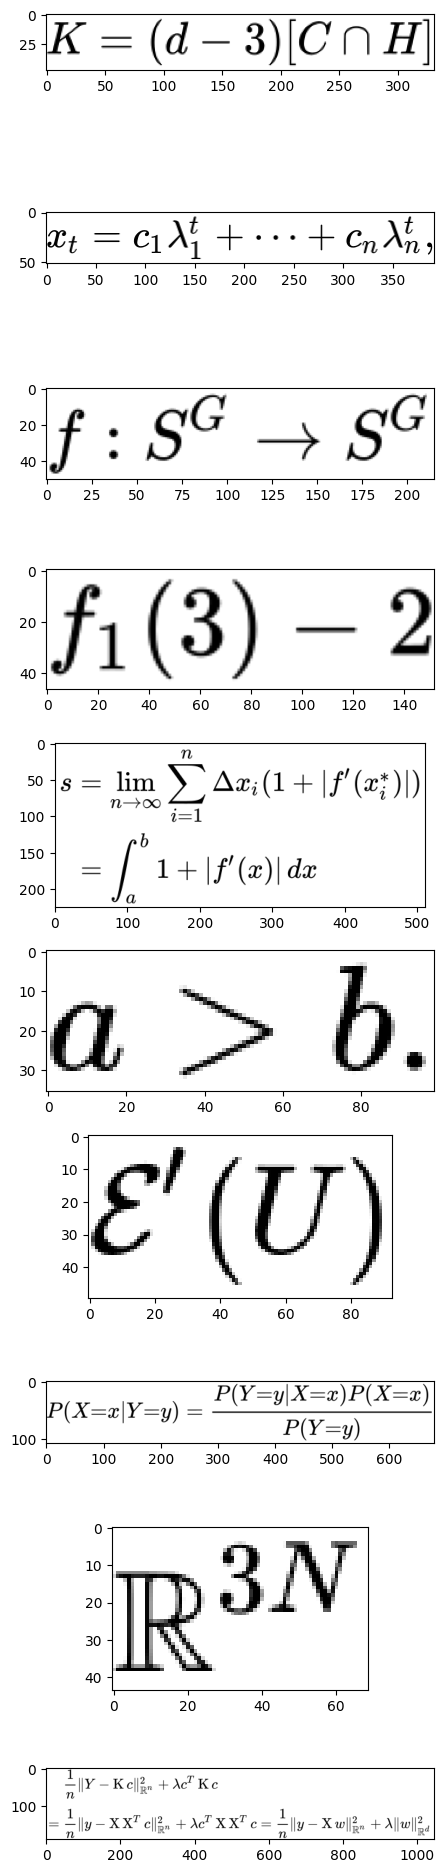

In [24]:
# display 10 random images from the set
random.seed(time.time())

indexes = list(range(dataset.num_rows))
random.shuffle(indexes)
selected_indexes = indexes[:10]

fig, axes = plt.subplots(10, 1, figsize=(5, 25))

for i, index in enumerate(selected_indexes):
    axes[i].imshow(dataset[index]["image"])

plt.show()